<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/moon_nice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [152]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn import datasets
from sklearn.datasets import load_digits
from sklearn.datasets import make_moons

In [153]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(input_dim), requires_grad=True)


    def forward(self, x):
        return self.f(x)

    def coupling_layer(self, x, m, flow, forward=True):
        x = x.clone()

        x_a = x[:, 0].reshape((-1,1)) if flow%2==0 else x[:, 1].reshape((-1,1))
        x_b = x[:, 1].reshape((-1,1)) if flow%2==0 else x[:, 0].reshape((-1,1))

        if forward:
            y_b = (x_b - m(x_a))
        else:
            y_b = (x_b + m(x_a))

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)

        z[:, 0] = x_a.reshape(-1,) if flow%2==0 else y_b.reshape(-1,)
        z[:, 1] = y_b.reshape(-1,) if flow%2==0 else x_a.reshape(-1,)
        return z


    def f(self, x):
        z = x

        for flow, model in enumerate(self.m, start=0):
            z = self.coupling_layer(z, model, flow, forward=True)

        z = z * torch.exp(self.s)
        log_det_j = torch.sum(self.s)

        return z, log_det_j

    def f_inv(self, z):
        x = z / torch.exp(self.s)

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            x = self.coupling_layer(x, model, flow,forward=False)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) + log_det_j).mean()
        return loss

In [154]:
data_dim = 2
prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))

model = NICE(input_dim=data_dim, hidden_layer=32, num_flows=4)

In [155]:
X,y = datasets.make_moons(n_samples=5000, shuffle=True, noise=0.01, random_state=1234)
x = torch.tensor(X, dtype=torch.float32)

train_loader = DataLoader(x, batch_size=100)

In [156]:
epochs = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%100 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  2.236321413516998
Epoch :  100   -----------> Loss :  -0.1273265700181946
Epoch :  200   -----------> Loss :  -0.5984624043107033
Epoch :  300   -----------> Loss :  -0.7489374423027039
Epoch :  400   -----------> Loss :  -0.6822796702384949
Epoch :  500   -----------> Loss :  -0.8573461961746216
Epoch :  600   -----------> Loss :  0.022011341922916473
Epoch :  700   -----------> Loss :  -0.7430354496836662
Epoch :  800   -----------> Loss :  -0.2867278916947544
Epoch :  900   -----------> Loss :  -0.9074466967582703
Epoch :  1000   -----------> Loss :  0.44084857164416463


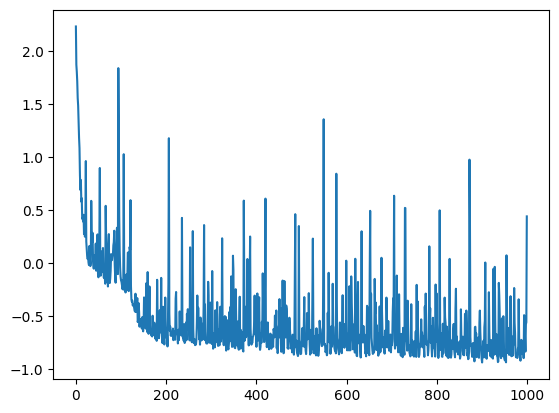

In [157]:
plt.plot(COST)

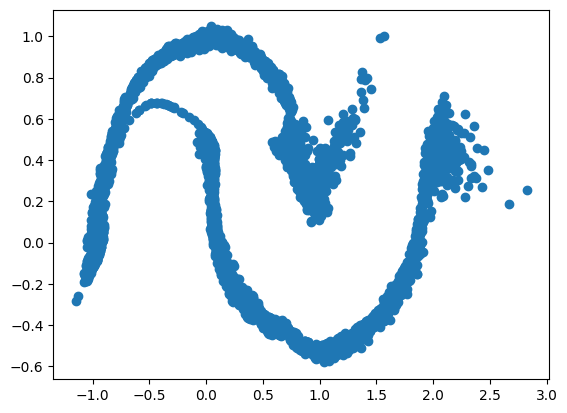

In [165]:
test = prior.sample((5000,))
sonuc = model.f_inv(test)
plt.scatter(sonuc[:,0].detach().numpy(), sonuc[:,1].detach().numpy())